In [221]:
import numpy as np 
import matplotlib.pyplot as plt 
import pickle 
from scipy.spatial import distance 
from sklearn.preprocessing import StandardScaler 
from skimage import measure, feature 
from tqdm.auto import tqdm, trange
import torch
from stedfm.loaders import get_dataset
from stedfm import get_pretrained_model_v2

DEEP_TREE_PATH = "./recursive-clustering-experiment/deep/MAE_SMALL_STED_neural-activity-states_recursive_clusters_tree.pkl"
MANUAL_TREE_PATH = "./recursive-clustering-experiment/manual/MAE_SMALL_STED_neural-activity-states_recursive_clusters_tree.pkl"
PIXELSIZE = 0.015 # in um
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PER_PROTEIN = False

In [222]:
class Node:
    def __init__(self, cluster_id, depth, data=None):
        self.cluster_id = cluster_id
        self.depth = depth
        self.data = data
        self.parent = None
        self.children = []
    
    def add_child(self, child_node):
        child_node.parent = self
        self.children.append(child_node)
    
    def __str__(self):
        return f"Node(cluster_id={self.cluster_id}, depth={self.depth}, children={len(self.children)})"
    
    def __repr__(self):
        return self.__str__()

def print_tree(node, indent=0):
    """Helper function to visualize the tree structure"""
    print("  " * indent + str(node))
    if node.data is not None:
        print("  " * (indent + 1) + f"Data: {node.data}")
    for child in node.children:
        print_tree(child, indent + 1)

def build_tree_from_nested_lists(nested_lists, depth=0, parent_id=0):
    """
    Recursively builds a tree from nested lists.
    
    Args:
        nested_lists: A list that may contain nested lists or data elements
        depth: Current depth in the tree
        parent_id: Cluster ID of the parent node
    
    Returns:
        The root node of the tree
    """
    # Create a root node for the current level
    current_id = parent_id
    root = Node(cluster_id=current_id, depth=depth)
    
    # Process each item in the nested list
    for i, item in enumerate(nested_lists):
        # Assign a unique cluster ID for the current node
        current_id = parent_id * 100 + i + 1
        
        if isinstance(item, list):
            # Recursive case: item is a nested list (cluster)
            child_node = build_tree_from_nested_lists(item, depth + 1, current_id)
            root.add_child(child_node)
            # print(f"child_node: {child_node.parent}")
        else:
            # Base case: item is data
            leaf_node = Node(cluster_id=current_id, depth=depth + 1, data=item)
            root.add_child(leaf_node)
            # print(f"leaf_node: {leaf_node.parent}")
    
    return root

def load_data(data_path: str):
    with open(data_path, "rb") as f:
        data = pickle.load(f)
    return data

def find_leaf_nodes(node, leaves=None):
    if leaves is None:
        leaves = []
    
    if not node.children:  # This is a leaf node
        leaves.append(node)
    else:
        for child in node.children:
            find_leaf_nodes(child, leaves)
            
    return leaves

def get_depth_nodes(root, depth):
    for child in root.children:
        if child.depth == depth:
            yield child
        else:
            yield from get_depth_nodes(child, depth)

    

In [223]:
_, _, test_loader = get_dataset(
    name="neural-activity-states",
    transform=None, 
    training=True,
    n_channels=1,
    balance=False,
    batch_size=64
)

dataset = test_loader.dataset 

Processing dataset..: 100%|██████████| 1510/1510 [00:01<00:00, 1219.79it/s]


=== NAS dataset ===
(array([0, 1, 2, 3]), array([1545, 1423,  512, 2541]))
(array([0, 1, 2, 3]), array([230, 420, 113, 413]))
(array([0, 1, 2, 3]), array([492, 299, 200, 519]))
Training size: 6021
Validation size: 1176
Test size: 1510




In [224]:
model, config = get_pretrained_model_v2(
    name="mae-lightning-small",
    weights="MAE_SMALL_STED",
    path=None,
    mask_ratio=0.0, 
    pretrained=True,
    in_channels=1,
    as_classifier=True,
    blocks="all",
    num_classes=4
)
model.eval()
model.to(DEVICE)

mask_ratio 0.0
pretrained True
in_channels 1
blocks all
num_classes 4
--- mae-lightning-small | /home-local/Frederic/baselines/mae-small_STED/pl_checkpoint-999.pth ---

--- Loaded model mae-lightning-small with weights MAE_SMALL_STED ---
--- ViT case with none-ImageNet weights or from scratch ---
--- Freezing every parameter in mae-lightning-small ---
--- Added linear probe to all frozen blocks ---


LinearProbe(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 384, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none

In [208]:
vit_data, manual_data = load_data(DEEP_TREE_PATH), load_data(MANUAL_TREE_PATH)
vit_tree, manual_tree = build_tree_from_nested_lists(vit_data), build_tree_from_nested_lists(manual_data)

In [225]:
def get_handcrafted_features(img, mask):
    # m, M = img.min(), img.max()
    # img = (img - m) / (M - m)
    mask_label, num_proteins = measure.label(mask, return_num=True)
    # print(f"--- {num_proteins} proteins in image ---")
    props = measure.regionprops(mask_label, intensity_image=img)
    coordinates = np.array([p.weighted_centroid for p in props])
    distances = distance.pdist(coordinates) * PIXELSIZE 
    distances = distance.squareform(distances)

    if distances.shape[0] <= 1:
        nn_distances = [30.0]
    else:
        nn_distances = np.sort(distances, axis=1)[:, 1]
    density_proteins = (np.sum(distances < 0.5, axis=1) - 1) / 1 # in number of proteins per um^2
    br = measure.blur_effect(img)
    shannon_entropy = measure.shannon_entropy((img)) 
    foreground_intensity = np.mean(img[mask])
    inverted_mask = np.logical_not(mask)
    background_intensity = np.mean(img[inverted_mask])
    snr = (foreground_intensity - background_intensity) / background_intensity
    features = []
    for prop, density, nn in zip(props, density_proteins, nn_distances):
        if np.isnan(nn):
            nn = 30.0
        label = prop.image 
        min_distance = int(0.08 / PIXELSIZE) // 2 + 1
        peaks = feature.peak_local_max(img, min_distance=min_distance, exclude_border=False, labels=label)
        features.append([
            prop.area,
            prop.perimeter,
            prop.mean_intensity,
            prop.eccentricity,
            prop.major_axis_length,
            prop.minor_axis_length,
            prop.solidity,
            density,
            nn,
            len(peaks),
            br,
            shannon_entropy,
            snr
        ])
    return np.array(features)

def get_deep_features(img: np.ndarray, model: torch.nn.Module):
    torch_img = torch.tensor(img[np.newaxis, ...]).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        features = model.forward_features(torch_img)
        features = features.squeeze().cpu().numpy()
    return features


def get_node_features(node, dataset, model: torch.nn.Module = None, extract_deep: bool = False, per_protein: bool = False):
    try:
        data_idx = [item["dataset-idx"].item() for item in node.data["metadata"]]
    except:
        data_idx = [item["dataset-idx"] for item in node.data["metadata"]]

    imgs = [dataset[idx][0].squeeze().numpy() for idx in data_idx]
    masks = [dataset[idx][1]["mask"] for idx in data_idx]
    conditions = [dataset[idx][1]["condition"] for idx in data_idx]
    handcrafted_features = [] if not per_protein else None
    deep_features = []

    for img, mask in zip(imgs, masks):
        # handcrafted features
        h_features = get_handcrafted_features(img=img, mask=mask)
        if np.any(np.isnan(h_features)):
            print("Woops")
            print(h_features)
            print("\n\n")
        if not per_protein:
            h_features = np.mean(h_features, axis=0)
            handcrafted_features.append(h_features) 
        else:
            if handcrafted_features is None:
                handcrafted_features = h_features
            else:
                handcrafted_features = np.concatenate((handcrafted_features, h_features), axis=0)

        # deep features
        if extract_deep:
            d_features = get_deep_features(img=img, model=model)
            deep_features.append(d_features)

    handcrafted_features = np.array(handcrafted_features)
    deep_features = np.array(deep_features) if extract_deep else None

    return handcrafted_features, deep_features, conditions

In [226]:
def fit_scaler(tree):
    scaler = StandardScaler()
    leaf_nodes = find_leaf_nodes(tree)
    all_features = None
    for node in tqdm(leaf_nodes):
        features, _, conditions = get_node_features(node=node, dataset=dataset, per_protein=PER_PROTEIN)
        if all_features is None:
            all_features = features
        else:
            all_features = np.concatenate((all_features, features), axis=0)
    print(all_features.shape)
    all_features = np.array(all_features)
   
    scaler.fit(all_features)
    scaler.transform(all_features)
    max_features = np.quantile(all_features, axis=0, q=0.90)
    min_features = np.quantile(all_features, axis=0, q=0.10)
    return scaler, max_features, min_features

SCALER, max_features, min_features = fit_scaler(tree=vit_tree)

  0%|          | 0/68 [00:00<?, ?it/s]/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/skimage/measure/_regionprops.py:647: RuntimeWarning: invalid value encountered in scalar divide
  tuple(M[_get_element(axis)] / M0 for axis in range(self._ndim)))
100%|██████████| 68/68 [00:36<00:00,  1.86it/s]

(1510, 13)


## Extracting features

In [227]:
from collections import defaultdict

def extract_features(root, model: torch.nn.Module, extract_deep: bool = True):
    handcrafted_subtypes, deep_subtypes = {}, {}
    handcrafted_features, deep_features = {}, {}
    all_conditions, majority_conditions = {}, defaultdict(str)
    leaf_nodes = find_leaf_nodes(root)
    for node in tqdm(leaf_nodes):
        hfeatures, dfeatures, conditions = get_node_features(node=node, dataset=dataset, model=model, extract_deep=extract_deep, per_protein=PER_PROTEIN)
        unique_conditions, counts = np.unique(conditions, return_counts=True)
        mc = unique_conditions[np.argmax(counts)]
        hfeatures = SCALER.transform(hfeatures)
        avg_hfeatures = np.mean(hfeatures, axis=0)
        handcrafted_subtypes[node.cluster_id] = avg_hfeatures
        handcrafted_features[node.cluster_id] = hfeatures 
        all_conditions[node.cluster_id] = conditions 
        majority_conditions[node.cluster_id] = mc  
        if extract_deep:
            avg_dfeatures = np.mean(dfeatures, axis=0) 
            deep_subtypes[node.cluster_id] = avg_dfeatures
            deep_features[node.cluster_id] = dfeatures

    return {
        "handcrafted_subtypes": handcrafted_subtypes, 
        "handcrafted_features": handcrafted_features, 
        "deep_subtypes": deep_subtypes, 
        "deep_features": deep_features, 
        "conditions": all_conditions,
        "majority_conditions": majority_conditions
    }


In [228]:
root_vit_data = extract_features(root=vit_tree, model=model, extract_deep=True)
root_manual_data = extract_features(root=manual_tree, model=model, extract_deep=True)


  0%|          | 0/68 [00:00<?, ?it/s]

/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/skimage/measure/_regionprops.py:647: RuntimeWarning: invalid value encountered in scalar divide
  tuple(M[_get_element(axis)] / M0 for axis in range(self._ndim)))
 76%|███████▋  | 52/68 [00:41<00:06,  2.57it/s]/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/skimage/measure/_regionprops.py:647: RuntimeWarning: invalid value encountered in scalar divide
  tuple(M[_get_element(axis)] / M0 for axis in range(self._ndim)))
100%|██████████| 45/45 [00:47<00:00,  1.05s/it]


In [229]:
vit_deep_subtypes = root_vit_data["deep_subtypes"]
vit_deep_features = root_vit_data["deep_features"]
vit_handcrafted_subtypes = root_vit_data["handcrafted_subtypes"]
vit_handcrafted_features = root_vit_data["handcrafted_features"]

manual_deep_subtypes = root_manual_data["deep_subtypes"]
manual_deep_features = root_manual_data["deep_features"]
manual_handcrafted_subtypes = root_manual_data["handcrafted_subtypes"]
manual_handcrafted_features = root_manual_data["handcrafted_features"]

vit_conditions = root_vit_data["conditions"]
vit_majority_conditions = root_vit_data["majority_conditions"]

manual_conditions = root_manual_data["conditions"]
manual_majority_conditions = root_manual_data["majority_conditions"]


temporary_key = list(vit_deep_subtypes.keys())[0] 
print(vit_deep_subtypes[temporary_key].shape, vit_deep_features[temporary_key].shape, vit_handcrafted_subtypes[temporary_key].shape, vit_handcrafted_features[temporary_key].shape)
print(len(vit_conditions[temporary_key]), len(vit_majority_conditions[temporary_key]))

temporary_key = list(manual_deep_subtypes.keys())[0] 
print(manual_deep_subtypes[temporary_key].shape, manual_deep_features[temporary_key].shape, manual_handcrafted_subtypes[temporary_key].shape, manual_handcrafted_features[temporary_key].shape)
print(len(manual_conditions[temporary_key]), len(manual_majority_conditions[temporary_key]))




(384,) (374, 384) (13,) (374, 13)
374 5
(384,) (16, 384) (13,) (16, 13)
16 5


## Similarity between leaf nodes (average feature vectors)

In [230]:
def compute_intergraph_node_similarity(data1: dict, data2: dict, feature_key: str = "deep_subtypes", metric: str = "cosine"):
    all_f1, all_f2 = data1[feature_key], data2[feature_key]
    f1 = np.array(list(all_f1.values())) 
    f2 = np.array(list(all_f2.values())) 
    distance_matrix = distance.cdist(f1, f2, metric=metric)
    f1_distances = np.min(distance_matrix, axis=1)
    random_distances = np.random.choice(distance_matrix.ravel(), size=f1_distances.shape[0], replace=False)
    f2_distances = np.min(distance_matrix, axis=0)
    f1_distances = np.sort(f1_distances)
    f2_distances = np.sort(f2_distances)
    random_distances = np.sort(random_distances)
    y1 = np.linspace(0, 1, len(f1_distances))
    y2 = np.linspace(0, 1, len(f2_distances))
    yrandom = np.linspace(0, 1, len(random_distances))
    fig = plt.figure(figsize=(4, 3))
    ax = fig.add_subplot(111)
    ax.plot(f1_distances, y1, label="ViT to manual", color="fuchsia")
    ax.plot(f2_distances, y2, color="dodgerblue", label="Manual to ViT")
    # ax.plot(random_distances, yrandom, color="black", ls="--", label="Random")
    dims = "384D" if feature_key == "deep_subtypes" else "11D"
    ax.set_title(f"{feature_key} ({dims})")
    # ax.set_xscale("log")
    plt.legend()
    plt.show

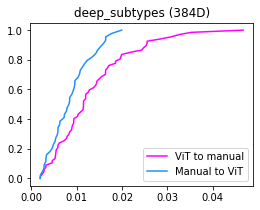

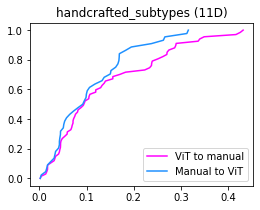

In [231]:
compute_intergraph_node_similarity(root_vit_data, root_manual_data, feature_key="deep_subtypes", metric="cosine")
compute_intergraph_node_similarity(root_vit_data, root_manual_data, feature_key="handcrafted_subtypes", metric="cosine")

**Main takeway**: The ViT-clustered graph has more nodes whose information is not contained in the nodes of the manual-clustered graph, whereas much of the information contained in the nodes of the manual-clustered graph can be retrieved from the nodes of the ViT-clustered graph.

In [232]:
def compute_intragraph_node_similarity(data1: dict, data2: dict, feature_key: str = "deep_subtypes", metric: str = "cosine"):
    all_f1, all_f2 = data1[feature_key], data2[feature_key]
    f1 = np.array(list(all_f1.values())) 
    f2 = np.array(list(all_f2.values())) 
    distance_matrix1 = distance.cdist(f1, f1, metric=metric)
    distance_matrix2 = distance.cdist(f2, f2, metric=metric)

    f1_distances, f2_distances = [], [] 
    for i in range(distance_matrix1.shape[0]):
        distance_row = np.sort(distance_matrix1[i, :])
        d = distance_row[1]
        f1_distances.append(d)
    for i in range(distance_matrix2.shape[0]):
        distance_row = np.sort(distance_matrix2[i, :])
        d = distance_row[1]
        f2_distances.append(d)
    
    f1_distances = np.sort(f1_distances)
    f2_distances = np.sort(f2_distances)
    y1 = np.linspace(0, 1, len(f1_distances))
    y2 = np.linspace(0, 1, len(f2_distances))
    fig = plt.figure(figsize=(4, 3))
    ax = fig.add_subplot(111)
    ax.plot(f1_distances, y1, label="ViT to ViT", color="fuchsia")
    ax.plot(f2_distances, y2, color="dodgerblue", label="Manual to manual")
    dims = "384D" if feature_key == "deep_subtypes" else "11D"
    ax.set_title(f"{feature_key} ({dims})")
    ax.set_ylabel("Cumulative sum")
    ax.set_xlabel("Nearest node distance")
    # ax.set_xscale("log")
    plt.legend()
    plt.show
    

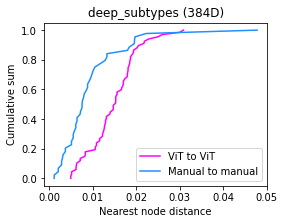

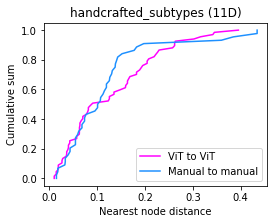

In [233]:
compute_intragraph_node_similarity(root_vit_data, root_manual_data, feature_key="deep_subtypes", metric="cosine")
compute_intragraph_node_similarity(root_vit_data, root_manual_data, feature_key="handcrafted_subtypes", metric="cosine")

**Main takeaway**: Node information in the same graph is more "orthogonal" in the ViT-clustered graph, since nodes muchmust be transported along generally larger distances to the most similar node of the same graph than nodes in the manual-clustered graph

In [234]:
def majority_class_distributions(c1, c2):
    """
    NOTE: Assumes that the ViT-graph conditions are in c1 and the manual-graph conditions in c2
    """
    majorities = defaultdict(list)
    for i, c in enumerate([c1, c2]):
        for key in c.keys():
            current_conditions = c[key]
            cnames, ccounts = np.unique(current_conditions, return_counts=True)
            total = sum(ccounts)
            majority = max(ccounts)
            ratio = majority / total 
            majorities[i].append(ratio)
    
    majority_c1, majority_c2 = list(majorities.values())
    majority_c1, majority_c2 = np.sort(majority_c1), np.sort(majority_c2)
    y1 = np.linspace(0, 1, len(majority_c1))
    y2 = np.linspace(0, 1, len(majority_c2))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(majority_c1, y1, color="fuchsia", label="Deep")
    ax.plot(majority_c2, y2, color="dodgerblue", label="Manual")
    ax.set_ylabel("Cumulative sum")
    ax.set_xlabel("Majority class percentage per node")
    plt.legend()
    plt.show()


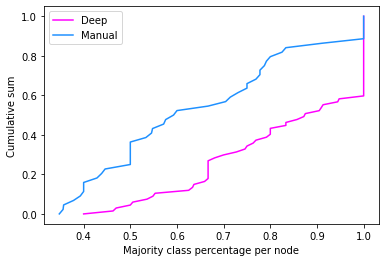

In [235]:
majority_class_distributions(c1=vit_conditions, c2=manual_conditions)

**Main takeaway**: The ViT-clustered graph is better at separating and isolating classes in nodes as there are more of its nodes in which the majority class accounts for a high percentage of the represented classes in that node.

## Similarity between nodes at a specific depth (average feature vectors)

In [78]:
def extract_depth_features(root, model: torch.nn.Module, extract_deep: bool = True, max_depth: int = 12):
    handcrafted_depth_subtypes = defaultdict(list)
    deep_depth_subtypes = defaultdict(list)
    for depth in trange(1, max_depth+1):
        depth_nodes = list(get_depth_nodes(root, depth))
        handcrafted_depth_vectors = []
        deep_depth_vectors = []
        for dn in depth_nodes:
            leaf_nodes = find_leaf_nodes(dn)
            current_deep_vectors = None
            current_handcrafted_vectors = None
            for node in leaf_nodes:
                hfeatures, dfeatures, _ = get_node_features(node, dataset=dataset, model=model, extract_deep=extract_deep)
            
                hfeatures = SCALER.transform(hfeatures)
                if current_handcrafted_vectors is None:
                    current_handcrafted_vectors = hfeatures
                else:
                    current_handcrafted_vectors = np.concatenate((current_handcrafted_vectors, hfeatures), axis=0)
                
                if extract_deep:
                    if current_deep_vectors is None:
                        current_deep_vectors = dfeatures
                    else:
                        current_deep_vectors = np.concatenate((current_deep_vectors, dfeatures), axis=0)
            current_deep_vectors = np.mean(current_deep_vectors, axis=0)
            current_handcrafted_vectors = np.mean(current_handcrafted_vectors, axis=0)
            handcrafted_depth_vectors.append(current_handcrafted_vectors)
            deep_depth_vectors.append(current_deep_vectors)
        handcrafted_depth_subtypes[depth] = np.array(handcrafted_depth_vectors)
        deep_depth_subtypes[depth] = np.array(deep_depth_vectors)
            
    return {
        "handcrafted_depth_subtypes": handcrafted_depth_subtypes,
        "deep_depth_subtypes": deep_depth_subtypes
    }

In [79]:
vit_depth_data = extract_depth_features(root=vit_tree, model=model, max_depth=9)
manual_depth_data = extract_depth_features(root=manual_tree, model=model, max_depth=10)

  0%|          | 0/9 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [40]:
def compute_intradepth_similarity(data1: dict, data2: dict, feature_key: str = "deep_depth_subtypes", func = np.mean):
    depth_vectors1 = data1[feature_key]
    depth_vectors2 = data2[feature_key]
    depth_distances1 = {}
    depth_distances2 = {}

    for k in depth_vectors1.keys():
        d_vector = depth_vectors1[k]
        d_distances = []
        for i in range(d_vector.shape[0]):
            row = d_vector[[i], :] 
           
            distance_vector = distance.cdist(row, d_vector, metric="cosine")[0]
            d = np.sort(distance_vector)[1]
            d_distances.append(d)
        depth_distances1[k] = np.array(d_distances) 
    
    for k in depth_vectors2.keys():
        d_vector = depth_vectors2[k]
        d_distances = []
        for i in range(d_vector.shape[0]):
            row = d_vector[[i], :] 
           
            distance_vector = distance.cdist(row, d_vector, metric="cosine")[0]
            d = np.sort(distance_vector)[1]
            d_distances.append(d)
        depth_distances2[k] = np.array(d_distances) 

    depth_distances1 = list(depth_distances1.values())[1:]
    depth_distances2 = list(depth_distances2.values())[1:]
    x1 = [0, 2, 4, 6, 8, 10, 12, 14] #, 16]
    x2 = [0.5, 2.5, 4.5, 6.5, 8.5, 10.5, 12.5, 14.5, 16.5] #, 18.5]
    width = 0.5
    # x2 = [item + width for item in x2]
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    deep_boxes = ax.boxplot(depth_distances1,  positions=x1, patch_artist=True)
    manual_boxes = ax.boxplot(depth_distances2,  positions=x2, patch_artist=True)
    for box in deep_boxes["boxes"]:
        # box.set_color("fuchsia")
        box.set_facecolor("fuchsia")
        box.set_alpha(0.5)
        
        box.set_linewidth(2)
    for median in deep_boxes["medians"]:
        median.set_color("black")
    for box in manual_boxes["boxes"]:
        # box.set_color("dodgerblue")
        box.set_facecolor("dodgerblue")
        box.set_linewidth(2)
        box.set_alpha(0.5)
    for median in manual_boxes["medians"]:
        median.set_color("black")
    ax.set_xticks([item - 0.45 for item in x2], labels=list(depth_vectors2.keys())[1:])
    ax.set_ylabel("Nearest node distance")
    ax.set_xlabel("Depth")
    dims = "384D" if feature_key == "deep_depth_subtypes" else "11D"
    ax.set_title(f"{feature_key} ({dims})")
    ax.set_yscale("log")
    custom_legend = [plt.scatter([], [], c="fuchsia", label="ViT"), plt.scatter([], [], c="dodgerblue", label="Manual")]
    plt.legend(handles=custom_legend, loc="upper right")
    plt.show()

            
        
        

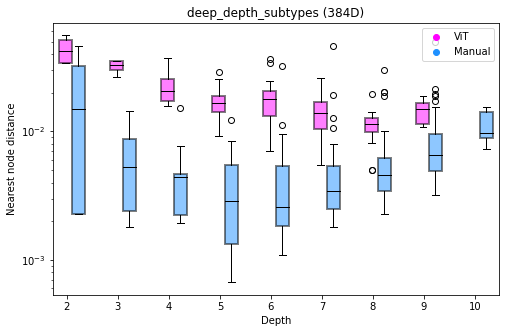

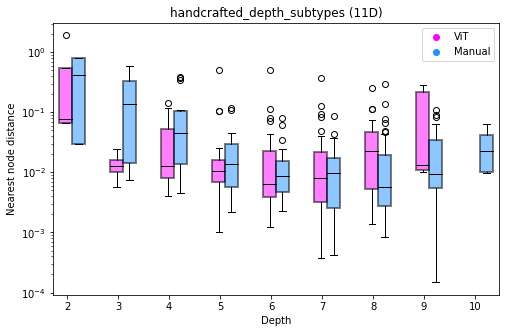

In [41]:
compute_intradepth_similarity(data1=vit_depth_data, data2=manual_depth_data, feature_key="deep_depth_subtypes")
compute_intradepth_similarity(data1=vit_depth_data, data2=manual_depth_data, feature_key="handcrafted_depth_subtypes")

**Main takeaways**: 
- For deep features, the ViT-clustered graph shows consistently more orthogonal information between nodes up until depth 8 or 9, after which it is similar to the manual-clustered graph. 
- For hand-crafted features however, the more orthogonal graph changes along the depth dimension. Manual-clustered graph is more orthogonal up until depth 4, after which the ViT-clustered graph is more orthogonal (except at depth 7).

*Note that we removed depth 1 as there are only two nodes at that depth for boths graphs, so the boxplot would give a single data point.*


## Similarity between nodes and its parent (average feature vectors)

In [251]:
def get_all_nodes(node, nodes=None):
    if nodes is None:
        nodes = [] 
    nodes.append(node)
    for child in node.children:
        get_all_nodes(child, nodes)
    return nodes
    

In [259]:
vit_all_nodes = get_all_nodes(vit_tree)
vit_all_nodes = [n for n in vit_all_nodes if n.parent is not None]
manual_all_nodes = get_all_nodes(manual_tree)
manual_all_nodes = [n for n in manual_all_nodes if n.parent is not None]

In [278]:
def compute_parent_distances(nodes, model: torch.nn.Module, extract_deep: bool = True):
    deep_distances = [] 
    handcrafted_distances = []
    for child in tqdm(nodes, total=len(nodes), desc="[---] Iterating over all nodes"):
        # Computing child average feature vector 
        child_leaves = find_leaf_nodes(child)
        child_hvector, parent_hvector = None, None
        child_dvector, parent_dvector = None, None
        for leaf in tqdm(child_leaves, total=len(child_leaves), desc="\t[---] Computing child average feature vector..."): 
            hf, df, _ = get_node_features(node=leaf, dataset=dataset, model=model, extract_deep=extract_deep)
            hf = SCALER.transform(hf)
            if child_hvector is None:
                child_hvector = hf
            else:
                child_hvector = np.concatenate((child_hvector, hf), axis=0)

            if extract_deep:
                if child_dvector is None:
                    child_dvector = df
                else:
                    child_dvector = np.concatenate((child_dvector, df), axis=0)
        child_hvector = np.mean(child_hvector, axis=0)
        child_dvector = np.mean(child_dvector, axis=0)

        # Computing parent average feature vector 
        parent = child.parent 
        parent_leaves = find_leaf_nodes(parent)
        parent_hvector, parent_dvector = None, None
        for leaf in tqdm(parent_leaves, total=len(parent_leaves), desc="\t[---] Computing parent average feature vector..."): 
            hf, df, _ = get_node_features(node=leaf, dataset=dataset, model=model, extract_deep=extract_deep)
            hf = SCALER.transform(hf)
            if parent_hvector is None:
                parent_hvector = hf
            else:
                parent_hvector = np.concatenate((parent_hvector, hf), axis=0)

            if extract_deep:
                if parent_dvector is None:
                    parent_dvector = df
                else:
                    parent_dvector = np.concatenate((parent_dvector, df), axis=0) 
        parent_hvector = np.mean(parent_hvector, axis=0)
        parent_dvector = np.mean(parent_dvector, axis=0)

        # Computing distance between child and parent 
        child_parent_hdistance = distance.cdist(child_hvector.reshape(1, -1), parent_hvector.reshape(1, -1), metric="cosine")[0][0]
        child_parent_ddistance = distance.cdist(child_dvector.reshape(1, -1), parent_dvector.reshape(1, -1), metric="cosine")[0][0]
        deep_distances.append(child_parent_ddistance)
        handcrafted_distances.append(child_parent_hdistance)
    return handcrafted_distances, deep_distances


In [279]:
vit_handcrafted_parent_distances, vit_deep_parent_distances = compute_parent_distances(nodes=vit_all_nodes, model=model, extract_deep=True)
manual_handcrafted_parent_distances, manual_deep_parent_distances = compute_parent_distances(nodes=manual_all_nodes, model=model, extract_deep=True)

[---] Iterating over all nodes:   0%|          | 0/134 [00:00<?, ?it/s]/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/skimage/measure/_regionprops.py:647: RuntimeWarning: invalid value encountered in scalar divide
  tuple(M[_get_element(axis)] / M0 for axis in range(self._ndim)))
	[---] Computing child average feature vector...: 100%|██████████| 26/26 [00:30<00:00,  1.17s/it]
/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/skimage/measure/_regionprops.py:647: RuntimeWarning: invalid value encountered in scalar divide
  tuple(M[_get_element(axis)] / M0 for axis in range(self._ndim)))
/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/skimage/measure/_regionprops.py:647: RuntimeWarning: invalid value encountered in scalar divide
  tuple(M[_get_element(axis)] / M0 for axis in range(self._ndim)))
[---] Iterating over all nodes:   1%|          | 1/134 [01:18<2:53:00, 78.05s/it]/opt/anaconda3/envs/phd-env/lib/python3.8/site-packages/skimage/measure/_regionprops.py:647: 

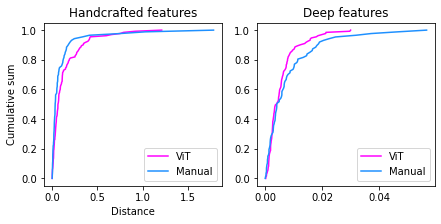

In [282]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
x1 = np.sort(vit_handcrafted_parent_distances)
y1 = np.linspace(0, 1, len(x1))
x2 = np.sort(manual_handcrafted_parent_distances)
y2 = np.linspace(0, 1, len(x2))
axs[0].plot(x1, y1, color="fuchsia", label="ViT")
axs[0].plot(x2, y2, color="dodgerblue", label="Manual")
axs[0].set_title("Handcrafted features")
axs[0].set_xlabel("Distance")
axs[0].set_ylabel("Cumulative sum") 
axs[0].legend()
x1 = np.sort(vit_deep_parent_distances)
y1 = np.linspace(0, 1, len(x1))
x2 = np.sort(manual_deep_parent_distances)
y2 = np.linspace(0, 1, len(x2))
axs[1].plot(x1, y1, color="fuchsia", label="ViT")
axs[1].plot(x2, y2, color="dodgerblue", label="Manual")
axs[1].set_title("Deep features")
axs[1].legend()
plt.show()

**Main takeaway**: Let's ignore this one

## Mapping vectors from one graph to nodes from another graph (vectors to subytpes)

In [236]:
def compute_mapping_matrix(features, subtypes, c1=None, c2=None, split_regions: bool = False, threshold=0.4):
    condition_dict = {c: i for i, c in enumerate(dataset.classes)}
    ax1_hlines = {}
    ax2_vlines = {}
    ax1_keys, ax2_keys = list(features.keys()), list(subtypes.keys())
    ax1_conditions = [c1[key] for key in ax1_keys]
    ax2_conditions = [c2[key] for key in ax2_keys]
    ax1_conditions = np.array([condition_dict[c] for c in ax1_conditions])
    ax2_conditions = np.array([condition_dict[c] for c in ax2_conditions])
    unique_c = np.unique(ax1_conditions)
    sorted_ax1_indices = np.argsort(ax1_conditions)
    sorted_ax2_indices = np.argsort(ax2_conditions)
    sorted_ax1_conditions = ax1_conditions[sorted_ax1_indices]
    sorted_ax2_conditions = ax2_conditions[sorted_ax2_indices]
    for c in unique_c:
        ax1_hlines[c] = np.where(sorted_ax1_conditions == c)[0][-1]
        ax2_vlines[c] = np.where(sorted_ax2_conditions == c)[0][-1]

    subtypes_array = np.array(list(subtypes.values()))
    mapping_matrix = np.zeros((len(list(features.keys())), subtypes_array.shape[0]))
    for k, key in enumerate(features.keys()):
        data = features[key]
        N = data.shape[0]
        mapped_to = [0] * subtypes_array.shape[0]
        for i in range(data.shape[0]):
            vector = data[i][np.newaxis, ...]
            distance_matrix = distance.cdist(vector, subtypes_array, metric="cosine")
            distances = np.argsort(distance_matrix, axis=1)[0]
            mapped_idx = distances[0]
            mapped_to[mapped_idx] += 1 
        mapped_to = [item / N for item in mapped_to]
        mapping_matrix[k] = mapped_to 
    
    if split_regions:
        mapping_matrix = mapping_matrix[sorted_ax1_indices, :]
        mapping_matrix = mapping_matrix[:, sorted_ax2_indices]
    return mapping_matrix, ax1_hlines, ax2_vlines

In [237]:
MAPPED_THRESHOLD = 0.4
LOWER_THRESHOLD = 0.05
UNIQUE_THRESHOLD = 0.4


vit_to_manual_deep, v_to_m_deep_hlines, v_to_m_deep_vlines = compute_mapping_matrix(features=vit_deep_features, subtypes=manual_deep_subtypes, c1=vit_majority_conditions, c2=manual_majority_conditions, split_regions=True)
manual_to_vit_deep, m_to_v_deep_hlines, m_to_v_deep_vlines = compute_mapping_matrix(features=manual_deep_features, subtypes=vit_deep_subtypes, c1=manual_majority_conditions, c2=vit_majority_conditions, split_regions=True)
vit_to_vit_deep, v_to_v_deep_hlines, v_to_v_deep_vlines = compute_mapping_matrix(features=vit_deep_features, subtypes=vit_deep_subtypes, c1=vit_majority_conditions, c2=vit_majority_conditions, split_regions=True)
manual_to_manual_deep, m_to_m_deep_hlines, m_to_m_deep_vlines = compute_mapping_matrix(features=manual_deep_features, subtypes=manual_deep_subtypes, c1=manual_majority_conditions, c2=manual_majority_conditions, split_regions=True)

vit_to_manual_handcrafted, v_to_m_handcrafted_hlines, v_to_m_handcrafted_vlines = compute_mapping_matrix(features=vit_handcrafted_features, subtypes=manual_handcrafted_subtypes, c1=vit_majority_conditions, c2=manual_majority_conditions, split_regions=True)
manual_to_vit_handcrafted, m_to_v_handcrafted_hlines, m_to_v_handcrafted_vlines = compute_mapping_matrix(features=manual_handcrafted_features, subtypes=vit_handcrafted_subtypes, c1=manual_majority_conditions, c2=vit_majority_conditions, split_regions=True)
vit_to_vit_handcrafted, v_to_v_handcrafted_hlines, v_to_v_handcrafted_vlines = compute_mapping_matrix(features=vit_handcrafted_features, subtypes=vit_handcrafted_subtypes, c1=vit_majority_conditions, c2=vit_majority_conditions, split_regions=True)
manual_to_manual_handcrafted, m_to_m_handcrafted_hlines, m_to_m_handcrafted_vlines = compute_mapping_matrix(features=manual_handcrafted_features, subtypes=manual_handcrafted_subtypes, c1=manual_majority_conditions, c2=manual_majority_conditions, split_regions=True)

{'Block': 0, '0MgGlyBic': 1, 'GluGly': 2, '48hTTX': 3}


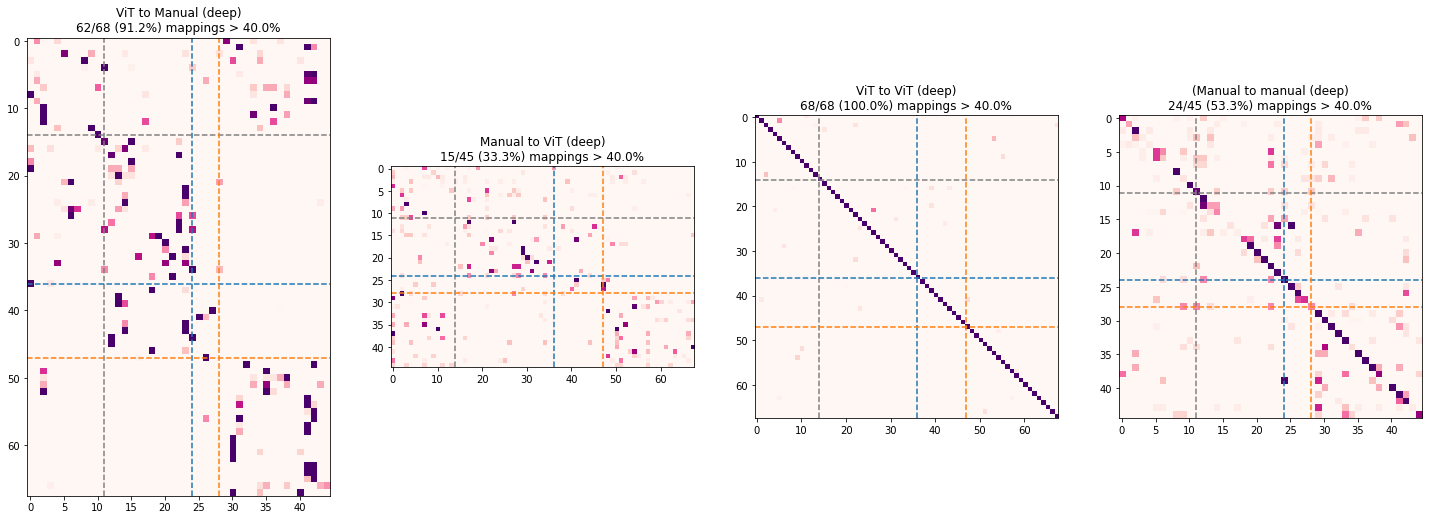

In [238]:
print({c: i for i, c in enumerate(dataset.classes)})
fig, axs = plt.subplots(1, 4, figsize=(25, 10))
axs[0].imshow(vit_to_manual_deep, cmap="RdPu", vmin=LOWER_THRESHOLD, vmax=MAPPED_THRESHOLD)
mapped = vit_to_manual_deep > MAPPED_THRESHOLD 
axs[0].set_title(f"ViT to Manual (deep)\n{mapped.sum()}/{vit_to_manual_deep.shape[0]} ({mapped.sum()/vit_to_manual_deep.shape[0]*100:.1f}%) mappings > {MAPPED_THRESHOLD*100}%")
for h, v, c in zip(list(v_to_m_deep_hlines.values())[:-1], list(v_to_m_deep_vlines.values())[:-1], ["grey", "tab:blue", "tab:orange"]):
    axs[0].axhline(h, color=c, ls="--")
    axs[0].axvline(v, color=c, ls="--")

axs[1].imshow(manual_to_vit_deep, cmap="RdPu", vmin=LOWER_THRESHOLD, vmax=MAPPED_THRESHOLD)
mapped = manual_to_vit_deep > MAPPED_THRESHOLD 
axs[1].set_title(f"Manual to ViT (deep)\n{mapped.sum()}/{manual_to_vit_deep.shape[0]} ({mapped.sum()/manual_to_vit_deep.shape[0]*100:.1f}%) mappings > {MAPPED_THRESHOLD*100}%")
for h, v, c in zip(list(m_to_v_deep_hlines.values())[:-1], list(m_to_v_deep_vlines.values())[:-1], ["grey", "tab:blue", "tab:orange"]):
    axs[1].axhline(h, color=c, ls="--")
    axs[1].axvline(v, color=c, ls="--")

axs[2].imshow(vit_to_vit_deep, cmap="RdPu", vmin=LOWER_THRESHOLD, vmax=MAPPED_THRESHOLD)
mapped = vit_to_vit_deep > MAPPED_THRESHOLD 
axs[2].set_title(f"ViT to ViT (deep)\n{mapped.sum()}/{vit_to_vit_deep.shape[0]} ({mapped.sum()/vit_to_vit_deep.shape[0]*100:.1f}%) mappings > {MAPPED_THRESHOLD*100}%")
for h, v, c in zip(list(v_to_v_deep_hlines.values())[:-1], list(v_to_v_deep_vlines.values())[:-1], ["grey", "tab:blue", "tab:orange"]):
    axs[2].axhline(h, color=c, ls="--")
    axs[2].axvline(v, color=c, ls="--")

axs[3].imshow(manual_to_manual_deep, cmap="RdPu", vmin=LOWER_THRESHOLD, vmax=MAPPED_THRESHOLD)
mapped = manual_to_manual_deep > MAPPED_THRESHOLD 
axs[3].set_title(f"(Manual to manual (deep)\n{mapped.sum()}/{manual_to_manual_deep.shape[0]} ({mapped.sum()/manual_to_manual_deep.shape[0]*100:.1f}%) mappings > {MAPPED_THRESHOLD*100}%")
for h, v, c in zip(list(m_to_m_deep_hlines.values())[:-1], list(m_to_m_deep_vlines.values())[:-1], ["grey", "tab:blue", "tab:orange"]):
    axs[3].axhline(h, color=c, ls="--")
    axs[3].axvline(v, color=c, ls="--")
plt.show()

{'Block': 0, '0MgGlyBic': 1, 'GluGly': 2, '48hTTX': 3}


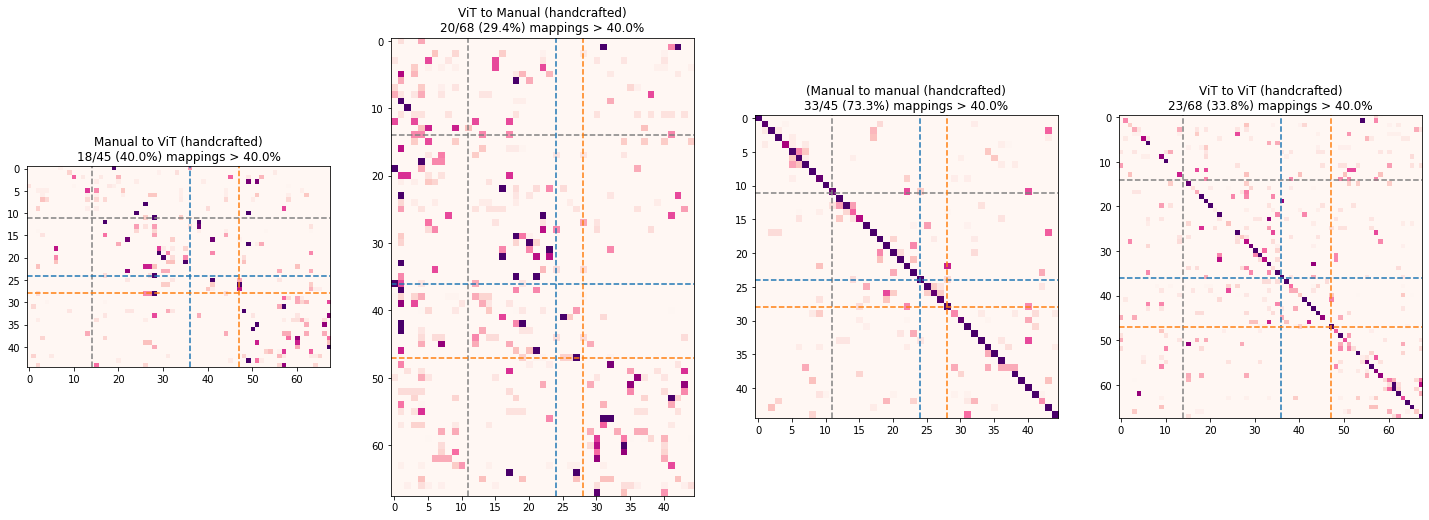

In [239]:

print({c: i for i, c in enumerate(dataset.classes)})

fig, axs = plt.subplots(1, 4, figsize=(25, 10))
axs[0].imshow(manual_to_vit_handcrafted, cmap="RdPu", vmin=LOWER_THRESHOLD, vmax=MAPPED_THRESHOLD)
mapped = manual_to_vit_handcrafted > MAPPED_THRESHOLD 
axs[0].set_title(f"Manual to ViT (handcrafted)\n{mapped.sum()}/{manual_to_vit_handcrafted.shape[0]} ({mapped.sum()/manual_to_vit_handcrafted.shape[0]*100:.1f}%) mappings > {MAPPED_THRESHOLD*100}%")
for h, v, c in zip(list(m_to_v_handcrafted_hlines.values())[:-1], list(m_to_v_handcrafted_vlines.values())[:-1], ["grey", "tab:blue", "tab:orange"]):
    axs[0].axhline(h, color=c, ls="--")
    axs[0].axvline(v, color=c, ls="--")

axs[1].imshow(vit_to_manual_handcrafted, cmap="RdPu", vmin=LOWER_THRESHOLD, vmax=MAPPED_THRESHOLD)
mapped = vit_to_manual_handcrafted > MAPPED_THRESHOLD 
axs[1].set_title(f"ViT to Manual (handcrafted)\n{mapped.sum()}/{vit_to_manual_handcrafted.shape[0]} ({mapped.sum()/vit_to_manual_handcrafted.shape[0]*100:.1f}%) mappings > {MAPPED_THRESHOLD*100}%")
for h, v, c in zip(list(v_to_m_handcrafted_hlines.values())[:-1], list(v_to_m_handcrafted_vlines.values())[:-1], ["grey", "tab:blue", "tab:orange"]):
    axs[1].axhline(h, color=c, ls="--")
    axs[1].axvline(v, color=c, ls="--")

axs[2].imshow(manual_to_manual_handcrafted, cmap="RdPu", vmin=LOWER_THRESHOLD, vmax=MAPPED_THRESHOLD)
mapped = manual_to_manual_handcrafted > MAPPED_THRESHOLD 
axs[2].set_title(f"(Manual to manual (handcrafted)\n{mapped.sum()}/{manual_to_manual_handcrafted.shape[0]} ({mapped.sum()/manual_to_manual_handcrafted.shape[0]*100:.1f}%) mappings > {MAPPED_THRESHOLD*100}%")
for h, v, c in zip(list(m_to_m_handcrafted_hlines.values())[:-1], list(m_to_m_handcrafted_vlines.values())[:-1], ["grey", "tab:blue", "tab:orange"]):
    axs[2].axhline(h, color=c, ls="--")
    axs[2].axvline(v, color=c, ls="--")

axs[3].imshow(vit_to_vit_handcrafted, cmap="RdPu", vmin=LOWER_THRESHOLD, vmax=MAPPED_THRESHOLD)
mapped = vit_to_vit_handcrafted > MAPPED_THRESHOLD 
axs[3].set_title(f"ViT to ViT (handcrafted)\n{mapped.sum()}/{vit_to_vit_handcrafted.shape[0]} ({mapped.sum()/vit_to_vit_handcrafted.shape[0]*100:.1f}%) mappings > {MAPPED_THRESHOLD*100}%")
for h, v, c in zip(list(v_to_v_handcrafted_hlines.values())[:-1], list(v_to_v_handcrafted_vlines.values())[:-1], ["grey", "tab:blue", "tab:orange"]):
    axs[3].axhline(h, color=c, ls="--")
    axs[3].axvline(v, color=c, ls="--")

plt.show()

**Main takeaways**:
- From graphs in the 3rd column: subtypes are more well-defined when using deep features. This is observed from the fact that: 
    - the ViT-clustered graph has 100% of nodes for which at least 40% of vectors map back to their subtype node whereas that percentage is only 82% for the manual-clustered graph.

In [59]:
def compute_mapping_proportions(mapping_matrix: np.ndarray, threshold: float, figax=None, **kwargs):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax 
    max_mapping = np.max(mapping_matrix, axis=1)
    N = max_mapping.shape[0]
    unique_ids = np.where(max_mapping <= threshold)[0]
    proportion_unique = len(unique_ids) / N 
    sorted_mappings = np.sort(max_mapping)

    ax.plot(sorted_mappings, np.linspace(0, 1, len(sorted_mappings)), **kwargs)
    return fig, ax

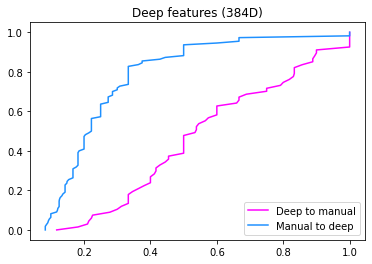

In [60]:
fig, ax = compute_mapping_proportions(
    mapping_matrix=vit_to_manual_deep, 
    threshold=MAPPED_THRESHOLD, 
    label="Deep to manual",
    color="fuchsia"
    )
fig, ax = compute_mapping_proportions(
    mapping_matrix=manual_to_vit_deep,
    threshold=MAPPED_THRESHOLD,
    label="Manual to deep",
    color="dodgerblue",
    figax=(fig, ax)
)
ax.set_title("Deep features (384D)")
plt.legend()
plt.show()

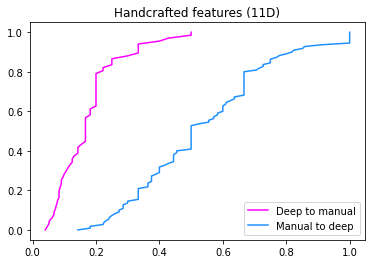

In [61]:
plt.close(fig)

fig, ax = compute_mapping_proportions(
    mapping_matrix=vit_to_manual_handcrafted, 
    threshold=MAPPED_THRESHOLD, 
    label="Deep to manual",
    color="fuchsia"
    )
fig, ax = compute_mapping_proportions(
    mapping_matrix=manual_to_vit_handcrafted,
    threshold=MAPPED_THRESHOLD,
    label="Manual to deep",
    color="dodgerblue",
    figax=(fig, ax)
)
ax.set_title("Handcrafted features (11D)")
plt.legend()
plt.show()